In [1]:
from pyspark.sql import SparkSession;

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession;

spark = SparkSession.builder.master("local[4]").appName("Spark Assignment").enableHiveSupport().getOrCreate();
# NOTE: 'local[4]' means that we are using 4 threads to run this spark session.

# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/05 17:15:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [3]:
# Set Spark log level to ERROR to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")

In [4]:
spark

In [5]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType, ArrayType
from pyspark.sql.functions import col, lower, regexp_replace, regexp_extract, split, lit, input_file_name

# Description of the Data

#### Source
The data for this analysis is sourced from the IMDb Large Movie Review Dataset, which comprises 50,000 highly polarized movie reviews. This dataset is leveraged to illustrate the application of advanced data processing techniques in Spark, making it ideal for this project's scope, which aims to delve deeply into sentiment analysis.

#### Structure
Organized into `train` and `test` directories, the dataset includes subfolders labeled `pos` (positive) and `neg` (negative) that categorize the reviews. Each review is stored as a text file named in the format `<id>_<rating>.txt`, where `<id>` is a unique identifier for the review, and `<rating>` reflects the movie rating on a scale from 1 to 10. This arrangement facilitates detailed analyses, such as sentiment classification and rating-based evaluations.

#### Content
The reviews, presented as raw text files, are directly read into a Spark DataFrame, encapsulated initially in a column named `value`. This raw textual content forms the foundation upon which various text mining techniques are applied, ensuring a robust analysis pipeline using PySpark.


The structure and content of this dataset provide an excellent framework for comprehensive text analysis, demonstrating Spark's robust capabilities in managing and processing substantial volumes of unstructured data. Utilizing this dataset allows us to not only apply a range of text mining techniques but also to derive meaningful insights that mirror the complexities encountered in real-world data science applications. Through this project, we explore the full potential of PySpark to perform intricate and large-scale text analysis, illustrating the practical impacts of these technologies in industry-relevant contexts.

# Data Loading
In this section, we'll load the movie reviews from both the training and testing folders and combine all of them into a single spark dataframe `reviews_df`.

In [6]:
# Path to the dataset directories
train_pos_path = "train/pos/"
train_neg_path = "train/neg/"
test_pos_path = "test/pos/"
test_neg_path = "test/neg/"

# Function to load data from a directory into a Spark DataFrame
def load_data(path, sentiment):
    df = spark.read.text(path).withColumn("sentiment", lit(sentiment))
    df = df.withColumn("filename", input_file_name())
    df = df.withColumn("rating", regexp_extract("filename", "_(\\d+)", 1).cast("integer"))
    df = df.drop("filename")
    return df

# Loading data
train_pos_df = load_data(train_pos_path, 1)  # Positive sentiment
train_neg_df = load_data(train_neg_path, 0)  # Negative sentiment
test_pos_df = load_data(test_pos_path, 1)
test_neg_df = load_data(test_neg_path, 0)

# Combine all data into a single DataFrame
from pyspark.sql import DataFrame
reviews_df = train_pos_df.union(train_neg_df).union(test_pos_df).union(test_neg_df)

Here, We have read the read from all text files in the folders and added sentiments based on their subfolder nane and added rating based on the filename. 

# Data Schema and Transformation
This step involves examining the data schema and performing initial transformations such as renaming columns and preparation of the text for further Exploratory Data Analysis.

In [7]:
# Print the schema of the DataFrame
reviews_df.printSchema()

root
 |-- value: string (nullable = true)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)



## 1. Handling Schema

After reviewing the initial data schema, a few transformations are necessary to enhance clarity and usability of the dataset for further analysis:

#### 1. Column Renaming
The original column name 'value' does not clearly indicate its content. It contains the text of movie reviews, so it is renamed to 'review' to accurately reflect its content.

#### 2. Data Types Review
Upon inspection, the data types for all columns are appropriately set:
- **review**: string
- **sentiment**: integer
- **rating**: integer
This setup aligns with our needs for any upcoming transformations and analysis. Therefore, no further data type changes are required at this stage.

#### 3. Handling Complex Data Structures
The dataset does not contain nested or complex data structures. All columns are in flat, simple formats which simplifies our analysis process and does not necessitate handling of complex data structures.


In [8]:
# Rename the 'value' column to 'review'
reviews_df = reviews_df.withColumnRenamed("value", "review")
reviews_df.printSchema()

root
 |-- review: string (nullable = true)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)



In [9]:
# Display the first 5 rows of the DataFrame with text truncated to 50 characters
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+
|                                            review|sentiment|rating|
+--------------------------------------------------+---------+------+
|Match 1: Tag Team Table Match Bubba Ray and Spi...|        1|     9|
|**Attention Spoilers**<br /><br />First of all,...|        1|     9|
|Titanic directed by James Cameron presents a fi...|        1|     9|
|By now you've probably heard a bit about the ne...|        1|    10|
|*!!- SPOILERS - !!*<br /><br />Before I begin t...|        1|    10|
+--------------------------------------------------+---------+------+
only showing top 5 rows



## 2. Data Transformations
This step involves preparing the data for analysis by performing necessary transformations and feature engineering. The data is cleansed by handling missing values, removing duplicates, and ensuring consistency in the text format.

In the initial text processing phase:

- a. Removing Punctuations and Converting to Lowercase
- b. Remove HTML Tags
- c. Handling Missing Values
- d. Dropping Duplicates

Next, feature engineering is applied to enrich the dataset with useful metrics:

- a. Word Count
- b. Count of Exclamation Marks
- c. Tokenization
- d. Stopword Removal
- e. Lemmatization
- f. Sentiment (Positive and Negative) Words Analysis


### Initial Text Processing
**a. Removing punctuations and Converting to lowercase**
- This step involves standardizing text by removing punctuation marks and converting to lowercase.

In [10]:
# Just before removing punctuation marks, we will count the number of exclamation marks as their presence 
# generally indicates heightened emotion or intensity rather than a specific sentiment direction

reviews_df = reviews_df.withColumn("exclamation_count", F.length(F.regexp_replace(col("review"), "[^!]", "")))

In [11]:
# Removing punctuation and converting text to lowercase

reviews_df = reviews_df.withColumn("review", F.lower(F.regexp_replace(F.col("review"), "[^a-zA-Z\\s]", "")))
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+-----------------+
|                                            review|sentiment|rating|exclamation_count|
+--------------------------------------------------+---------+------+-----------------+
|match  tag team table match bubba ray and spike...|        1|     9|               30|
|attention spoilersbr br first of all let me say...|        1|     9|                1|
|titanic directed by james cameron presents a fi...|        1|     9|                0|
|by now youve probably heard a bit about the new...|        1|    10|                1|
| spoilers  br br before i begin this let me say...|        1|    10|               12|
+--------------------------------------------------+---------+------+-----------------+
only showing top 5 rows



**b. Remove HTML tags**
- Further we can notice that the word br which is frequenctly used tag in html. So may be out data might have more tags like this lets remove these tags. As I already removed the punctuations, just removing the word would suffice here and I using `word< >` because there might be some words like `break` which might get affected if I replace just `br`.

In [12]:
# List of most common HTML tags to remove (you can expand this list as needed)
html_tags = ['br ', 'div ', 'p ', 'a ', 'li ', 'ul ', 'ol ', 'span ', 
             'h1 ', 'h2 ', 'h3 ', 'h4 ', 'h5 ', 'h6 ', 'tr ', 'td ']


html_tag_regex = '|'.join(html_tags)  # Creates a regex pattern like 'br|div|span|...'
html_tag_pattern = f"\\b({html_tag_regex})\\b"

# Removing HTML tags by replacing them with an empty string
reviews_df = reviews_df.withColumn("review", F.regexp_replace(col("review"), html_tag_pattern, ""))
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+-----------------+
|                                            review|sentiment|rating|exclamation_count|
+--------------------------------------------------+---------+------+-----------------+
|match  tag team table match bubba ray and spike...|        1|     9|               30|
|attention spoilersbr first of all let me say th...|        1|     9|                1|
|titanic directed by james cameron presents fict...|        1|     9|                0|
|by now youve probably heard bit about the new d...|        1|    10|                1|
| spoilers  before i begin this let me say that ...|        1|    10|               12|
+--------------------------------------------------+---------+------+-----------------+
only showing top 5 rows



In [13]:
reviews_df.show(5, truncate=50)

+--------------------------------------------------+---------+------+-----------------+
|                                            review|sentiment|rating|exclamation_count|
+--------------------------------------------------+---------+------+-----------------+
|match  tag team table match bubba ray and spike...|        1|     9|               30|
|attention spoilersbr first of all let me say th...|        1|     9|                1|
|titanic directed by james cameron presents fict...|        1|     9|                0|
|by now youve probably heard bit about the new d...|        1|    10|                1|
| spoilers  before i begin this let me say that ...|        1|    10|               12|
+--------------------------------------------------+---------+------+-----------------+
only showing top 5 rows



> All the unnecessary punctuations, html tags have been removed and we can see the text is clean in lowercase alphanumeric characters. 

**c. Handling Missing Values**
- This step involves checking for any missing or null values in the data and remove them as they can affect the accuracy of your analysis.

In [14]:
# Checking for null values in the DataFrame
reviews_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in reviews_df.columns]).show()

+------+---------+------+-----------------+
|review|sentiment|rating|exclamation_count|
+------+---------+------+-----------------+
|     0|        0|     0|                0|
+------+---------+------+-----------------+



> There are no null values in the current dataset, so handling them isn't necessary. However, in cases where null values might be present in future inputs, the following code is used to drop rows with null values.

In [15]:
# Dropping any rows that have missing values in any column
reviews_df = reviews_df.na.drop()

**d. Dropping Duplicate Rows**
- This step involves dropping duplicate columns if any exists in the dataset to avoid redundancy

In [16]:
# Initial Size of Dataset
reviews_df.count()

50000

In [17]:
# Removing duplicate rows based on 'review' and 'sentiment' columns
reviews_df = reviews_df.dropDuplicates(["review", "sentiment", "rating"])

# Size after removing duplicates
reviews_df.count()

49585

> This indicates that there were some duplicate reviews in the dataset, which have now been successfully removed.

## Feature Engineering
Feature engineering is a crucial step in preparing our dataset for deeper analysis and modeling.

**a. Word Count:** 
- This step involves measuring the number of words in each review provides a basic but useful feature for many text analysis tasks, as it can correlate with the intensity of sentiment.

In [18]:
from pyspark.sql.functions import size, split

# Calculating the number of words in each review
reviews_df = reviews_df.withColumn("word_count", size(split(col("review"), " ")))

**b. Presence of Exclamation Marks**(Already done before removing Punctuations)
- This step involves counting the exclamation marks as exclamation marks can indicate strong emotions, which is often related to sentiment.

In [19]:
# Calculating the number of Exclamation Marks in each review
# - this step was performed before removing punctuation marks.

**c. Tokenization**
- This step involves breaking down the text into tokens (words), as this makes the subsequent steps more manageable and structured

In [20]:
from pyspark.ml.feature import Tokenizer

# Tokenize the text to break down the review into words
tokenizer = Tokenizer(inputCol="review", outputCol="words")
reviews_df = tokenizer.transform(reviews_df)

**d. Stopwords Removal**
- This step involves removing common words that do not contribute significant meaning to the content.
- I am using custom stopwords because, using all the stopwords could actually remove words like `isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "don't", "doesn't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "couldn't", 'cannot'`, but these words are crucial in case of sentiment seperation.

In [21]:
from pyspark.ml.feature import StopWordsRemover

# Define a basic list of stopwords (verbs, prepositions, conjunctions)
# Expanded comprehensive stopwords list
basic_stopwords = [
    "is", "are", "was", "were", "be", "been", "am", "will", "would", "shall", "should", 
    "can", "could", "may", "might", "to", "from", "in", "on", "at", "with", "and", 
    "or", "but", "if", "the", "of", "it", "i", "this", "that", "he", "her", "she", 
    "him", "his", "they", "their", "them", "there", "who", "ha", "my", "mine", "you", 
    "your", "we", "our", "all", "what", "why", "how", "when", "where", "which", "a",
    "for", "by", "about", "into", "up", "down", "out", "as", "an", "so", "just", 
    "has", "have", "had", "having", "do", "does", "did", "doing", 
    "some", "any", "these", "those", "its", "then", "than", "once", "over", "under", 
    "again", "being", "because", "through", "off", "between", "before", "after", "such", 
    "until", "against", "during", "each", "both", "while", "further", "few", "must", "movie",
    "film", "one", "even", "too", "still", ""
]


# Apply the custom stopwords using StopWordsRemover
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=basic_stopwords)

# Apply the transformation to your DataFrame
reviews_df = remover.transform(reviews_df)

**e. Lemmatization**
- Lemmatization is a process of reducing words to their base or dictionary form (lemma), considering the morphological analysis of the words

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer
import nltk

# Ensure necessary resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define a UDF to apply lemmatization using NLTK's WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemmatization_udf = udf(lambda words: [lemmatizer.lemmatize(word) for word in words], ArrayType(StringType()))

# Apply lemmatization to the filtered words and update the review column
reviews_df = reviews_df.withColumn("review", lemmatization_udf("filtered_words"))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harshasaijagu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/harshasaijagu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**f. Sentiment Words Count**(After Stemming)
- This step involves counting predefined positive and negative words can provide direct insights into the sentiment of the review.
- This is done after stemming because, this ensures all forms of the word are recognized and counted correctly.


In [23]:
# Define comprehensive lists of positive and negative sentiment words
positive_words = [
    "excellent", "great", "perfect", "amazing", "positive", "enjoyable", "best",
    "wonderful", "fantastic", "loved", "liked", "brave", "good", "beautiful",
    "joyful", "happy", "satisfying", "delightful", "superb", "marvelous",
    "outstanding", "thrilling", "captivating", "charming", "impressive", "incredible",
    "stunning", "heartwarming", "uplifting", "rewarding", "memorable", "entertaining",
    "inspiring", "appealing", "engaging", "yes", "like", 
]

negative_words = [
    "bad", "worst", "terrible", "negative", "boring", "poor", "disappointing", "dull",
    "hated", "disliked", "awful", "horrible", "dreadful", "lame", "annoying", "crazy",
    "mad", "disgusting", "painful", "unwatchable", "monotonous", "tedious",
    "uninteresting", "lackluster", "predictable", "uninspired", "flop", "misfire",
    "bland", "soulless", "tiresome", "mundane", "flawed", "clumsy", "stale", "no", "not", 
    "wrong", 

]

In [24]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# UDF to count positive and negative words
def count_words_in_list(words, word_list):
    return sum(1 for word in words if word in word_list)

count_positive_words_udf = udf(lambda words: count_words_in_list(words, positive_words), IntegerType())
count_negative_words_udf = udf(lambda words: count_words_in_list(words, negative_words), IntegerType())

# Applying the UDFs to count occurrences of sentiment words
reviews_df = reviews_df.withColumn("positive_word_count", count_positive_words_udf("review"))
reviews_df = reviews_df.withColumn("negative_word_count", count_negative_words_udf("review"))

In [26]:
# Show the updated DataFrame after Feature Engineering
reviews_df.select('review', 'word_count', 'exclamation_count', 'positive_word_count', 'negative_word_count').show(5, truncate=25)

+-------------------------+----------+-----------------+-------------------+-------------------+
|                   review|word_count|exclamation_count|positive_word_count|negative_word_count|
+-------------------------+----------+-----------------+-------------------+-------------------+
|[looking, glass, see, ...|       962|                0|                  7|                 10|
|[hong, kong, given, wo...|      1027|                3|                 25|                  4|
|[anchor, aweigh, see, ...|      1039|                5|                 13|                  4|
|[angelopoulos, film, s...|       958|                0|                  4|                 10|
|[second, two, filmed, ...|       948|                0|                 11|                  8|
+-------------------------+----------+-----------------+-------------------+-------------------+
only showing top 5 rows



> From this, we can see that all the feature-engineered columns have been successfully added to the DataFrame, and the `review` column has been transformed through tokenization, stopword removal, and lemmatization.

# Data Storage

This step involves storing the data into persistent tables. Before storing the data into persistent tables, it's important to finalize the DataFrame schema to ensure it is ready for storage.

In [27]:
reviews_df.printSchema()

root
 |-- review: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)
 |-- exclamation_count: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- positive_word_count: integer (nullable = true)
 |-- negative_word_count: integer (nullable = true)



From the schema, we can observe that:

1. The `review` column is currently an array of words. To improve readability, it would be better to concatenate the words back into a single string.
2. The `words` and `filtered_words` columns are no longer needed, as the processed data is now fully contained in the `review` column. Dropping these columns will help reduce memory usage.

In [28]:
# Concatenate the 'review' array back into a single string column
reviews_df = reviews_df.withColumn("review", F.concat_ws(" ", "review"))

In [29]:
# Drop the 'words' and 'filtered_words' columns from the DataFrame
reviews_df = reviews_df.drop("words", "filtered_words")

In [30]:
# Check the updated DataFrame schema
reviews_df.printSchema()

root
 |-- review: string (nullable = false)
 |-- sentiment: integer (nullable = false)
 |-- rating: integer (nullable = true)
 |-- exclamation_count: integer (nullable = true)
 |-- word_count: integer (nullable = false)
 |-- positive_word_count: integer (nullable = true)
 |-- negative_word_count: integer (nullable = true)



The DataFrame is now fully flattened with an optimized schema, making it ready for storage in a persistent table. This streamlined structure is well-suited for efficient querying and analysis.

In [31]:
# Create the database 'movie_reviews_db' if it does not exist
spark.sql("CREATE DATABASE IF NOT EXISTS movie_reviews_db")

DataFrame[]

In [32]:
spark.sql("show databases").show()

+----------------+
|       namespace|
+----------------+
|         default|
|movie_reviews_db|
+----------------+



In [33]:
spark.sql("USE movie_reviews_db")

DataFrame[]

In [34]:
# Save the DataFrame as a persistent table with the name 'movie_reviews'
reviews_df.write.mode('overwrite').saveAsTable("movie_reviews")

# To confirm the table is created and to inspect some entries
spark.sql("SELECT * FROM movie_reviews").show(5, truncate=20)

+--------------------+---------+------+-----------------+----------+-------------------+-------------------+
|              review|sentiment|rating|exclamation_count|word_count|positive_word_count|negative_word_count|
+--------------------+---------+------+-----------------+----------+-------------------+-------------------+
|nyc seaman michae...|        1|    10|                0|       961|                  4|                  5|
|director douglas ...|        1|    10|                0|      1113|                 11|                  9|
|jim carrey back m...|        1|     9|                1|      1240|                 22|                  4|
|most important ar...|        1|     7|                0|       971|                 13|                  4|
|many adaptation c...|        1|    10|                0|       977|                 11|                 11|
+--------------------+---------+------+-----------------+----------+-------------------+-------------------+
only showing top 5 

> The data is saved in a structured format within a newly created database called `movie_reviews_db`. The processed DataFrame has been stored in a persistent table named `movie_reviews`, ensuring that the data is accessible for efficient querying and further analysis.

# Temporary View Creation

In [35]:
# Create a temporary view in Spark SQL
reviews_df.createOrReplaceTempView("movie_reviews_view")

# Data Exploration with Spark SQL


In [34]:
%load_ext sparksql_magic

### 1. Statistical Sumaries
Calculate mean, median, mode of numerical fields such as ratings and word counts

In [35]:
%%sparksql
SELECT 
    AVG(rating) AS mean_rating, 
    PERCENTILE_APPROX(rating, 0.5) AS median_rating, 
    AVG(word_count) AS mean_word_count, 
    PERCENTILE_APPROX(word_count, 0.5) AS median_word_count
FROM movie_reviews_view


mean_rating,median_rating,mean_word_count,median_word_count
5.508218211152566,7,222.77676716749016,167


### 2. Group Data by Sentiment
Group reviews by positive/negative sentiment and compute metrics like average rating, average word count, average exclamation marks:

In [36]:
%%sparksql
SELECT 
    sentiment, 
    COUNT(*) AS review_count, 
    AVG(rating) AS avg_rating, 
    AVG(word_count) AS avg_word_count,
    AVG(exclamation_count) AS avg_exclamation_marks
FROM movie_reviews_view
GROUP BY sentiment


sentiment,review_count,avg_rating,avg_word_count,avg_exclamation_marks
1,24887,8.76915658777675,224.43898420862297,0.929561618515691
0,24698,2.2223256943882097,221.10183010770103,1.027492104623856


In [37]:
# Run the SQL query and convert to a Pandas DataFrame
result_df = spark.sql("""
    SELECT 
        sentiment, 
        COUNT(*) AS review_count, 
        AVG(rating) AS avg_rating, 
        AVG(word_count) AS avg_word_count,
        AVG(exclamation_count) AS avg_exclamation_marks
    FROM movie_reviews_view
    GROUP BY sentiment
""").toPandas()

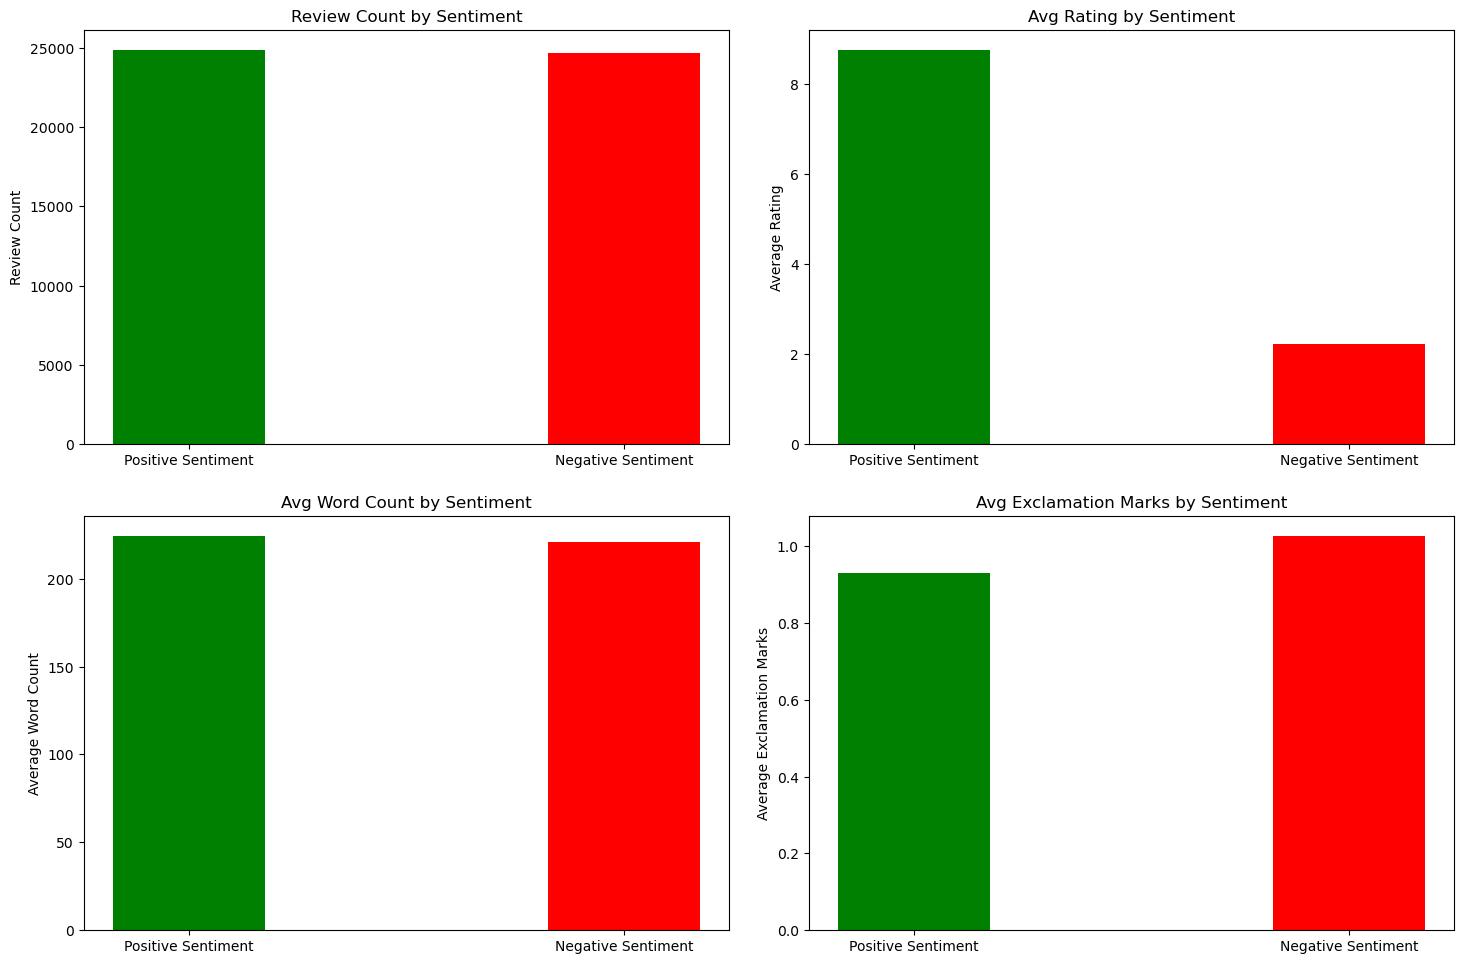

In [38]:
# Adjust the plot for better visual appeal, centering the bars in each subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Define the width of the bars and the position for each bar group
bar_width = 0.35
index = result_df['sentiment']

# Adjust the bar positions to be centered
index_positions = range(len(index))

# Review Count bar chart
axs[0, 0].bar(index_positions, result_df['review_count'], bar_width, color=['red' if x == 0 else 'green' for x in result_df['sentiment']])
axs[0, 0].set_title('Review Count by Sentiment')
axs[0, 0].set_xticks(index_positions)
axs[0, 0].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[0, 0].set_ylabel('Review Count')

# Avg Rating bar chart
axs[0, 1].bar(index_positions, result_df['avg_rating'], bar_width, color=['red' if x == 0 else 'green' for x in result_df['sentiment']])
axs[0, 1].set_title('Avg Rating by Sentiment')
axs[0, 1].set_xticks(index_positions)
axs[0, 1].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[0, 1].set_ylabel('Average Rating')

# Avg Word Count bar chart
axs[1, 0].bar(index_positions, result_df['avg_word_count'], bar_width, color=['red' if x == 0 else 'green' for x in result_df['sentiment']])
axs[1, 0].set_title('Avg Word Count by Sentiment')
axs[1, 0].set_xticks(index_positions)
axs[1, 0].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[1, 0].set_ylabel('Average Word Count')

# Avg Exclamation Marks bar chart
axs[1, 1].bar(index_positions, result_df['avg_exclamation_marks'], bar_width, color=['red' if x == 0 else 'green' for x in result_df['sentiment']])
axs[1, 1].set_title('Avg Exclamation Marks by Sentiment')
axs[1, 1].set_xticks(index_positions)
axs[1, 1].set_xticklabels(result_df['sentiment'].apply(lambda x: 'Negative Sentiment' if x == 0 else 'Positive Sentiment'))
axs[1, 1].set_ylabel('Average Exclamation Marks')

# Adjust layout to ensure bars are centered and have enough space around
plt.tight_layout(pad=2.0)
plt.show()


### 3. Sentiment by Review Length
Explore the relationship between review length (word count) and sentiment.

In [39]:
%%sparksql
SELECT 
    CASE 
        WHEN word_count < 150 THEN 'Short Reviews'
        WHEN word_count BETWEEN 150 AND 300 THEN 'Medium Reviews'
        ELSE 'Long Reviews'
    END AS review_length_category,
    sentiment, COUNT(*) AS count
FROM movie_reviews_view
GROUP BY review_length_category, sentiment
ORDER BY review_length_category

review_length_category,sentiment,count
Long Reviews,1,5294
Long Reviews,0,5030
Medium Reviews,0,9406
Medium Reviews,1,8965
Short Reviews,0,10262
Short Reviews,1,10628


### 3. Sentiment Analysis **
Analyze sentiment word counts for text:

In [40]:
%%sparksql
SELECT sentiment, AVG(positive_word_count) AS avg_positive_words, AVG(negative_word_count) AS avg_negative_words
FROM movie_reviews_view
GROUP BY sentiment


sentiment,avg_positive_words,avg_negative_words
1,3.396431872061719,1.9570458472294772
0,2.343185683051259,3.752652036602154


In [41]:
# Run the SQL query and convert to a Pandas DataFrame
result_df = spark.sql("""
    SELECT sentiment, AVG(positive_word_count) AS avg_positive_words, AVG(negative_word_count) AS avg_negative_words
    FROM movie_reviews_view
    GROUP BY sentiment
""").toPandas()


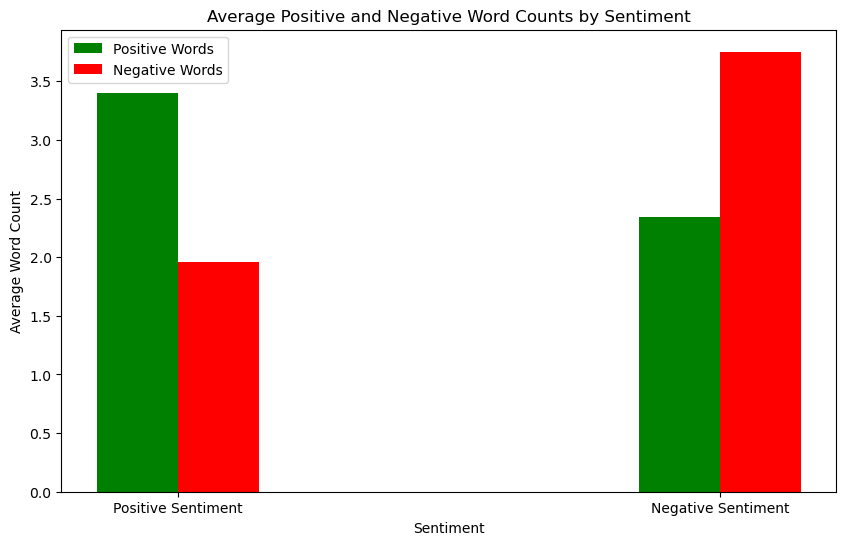

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars and the positions
bar_width = 0.15
index = np.arange(len(result_df))

# Plot the bars for positive and negative words
positive_bars = ax.bar(index, result_df['avg_positive_words'], bar_width, label='Positive Words', color='green')
negative_bars = ax.bar(index + bar_width, result_df['avg_negative_words'], bar_width, label='Negative Words', color='red')

# Add titles and labels
ax.set_xlabel('Sentiment')
ax.set_ylabel('Average Word Count')
ax.set_title('Average Positive and Negative Word Counts by Sentiment')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Positive Sentiment', 'Negative Sentiment'])
ax.legend()

# Show the plot
plt.show()


### Average Exclamation Mark Count by Rating **
Determine if higher or lower-rated movies use more exclamation marks.

In [43]:
%%sparksql
SELECT rating, AVG(exclamation_count) AS avg_exclamation_marks
FROM movie_reviews_view
GROUP BY rating
ORDER BY rating


rating,avg_exclamation_marks
1,1.3243785084202084
2,0.9770773638968482
3,0.858454007750357
4,0.6669822037107156
7,0.6162523501148945
8,0.6903457719958919
9,0.775888380204927
10,1.3020370178885328


In [44]:
# Run the Spark SQL query for average exclamation marks by rating
result_df = spark.sql("""
    SELECT rating, AVG(exclamation_count) AS avg_exclamation_marks
    FROM movie_reviews_view
    GROUP BY rating
    ORDER BY rating
""").toPandas()

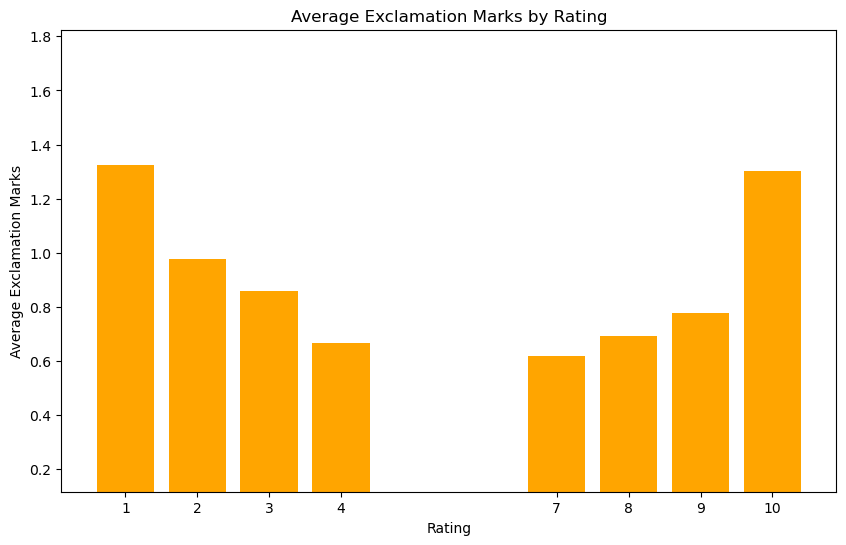

In [45]:
# Adjust the scale so the y-axis doesn't start from 0 for exclamation marks
plt.figure(figsize=(10, 6))
plt.bar(result_df['rating'], result_df['avg_exclamation_marks'], color='orange')

# Add titles and labels
plt.title('Average Exclamation Marks by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Exclamation Marks')

# Set y-axis limits to start from the minimum value of avg_exclamation_marks
plt.ylim(min(result_df['avg_exclamation_marks']) - 0.5, max(result_df['avg_exclamation_marks']) + 0.5)

# Show the plot
plt.xticks(result_df['rating'])  # Ensure all ratings are shown on x-axis
plt.show()


### Review Length Distribution by Rating **
Check if higher or lower ratings correspond to longer or shorter reviews.

In [46]:
%%sparksql
SELECT rating, AVG(word_count) AS avg_word_count
FROM movie_reviews_view
GROUP BY rating
ORDER BY rating


rating,avg_word_count
1,202.05232558139534
2,220.3206964954816
3,238.88965939220884
4,241.2396819386596
7,247.98746605389596
8,238.47381033892503
9,232.03422716372356
10,200.70230586288906


In [47]:
# Run the Spark SQL query and convert results to a Pandas DataFrame
result_df = spark.sql("""
    SELECT rating, AVG(word_count) AS avg_word_count
    FROM movie_reviews_view
    GROUP BY rating
    ORDER BY rating
""").toPandas()


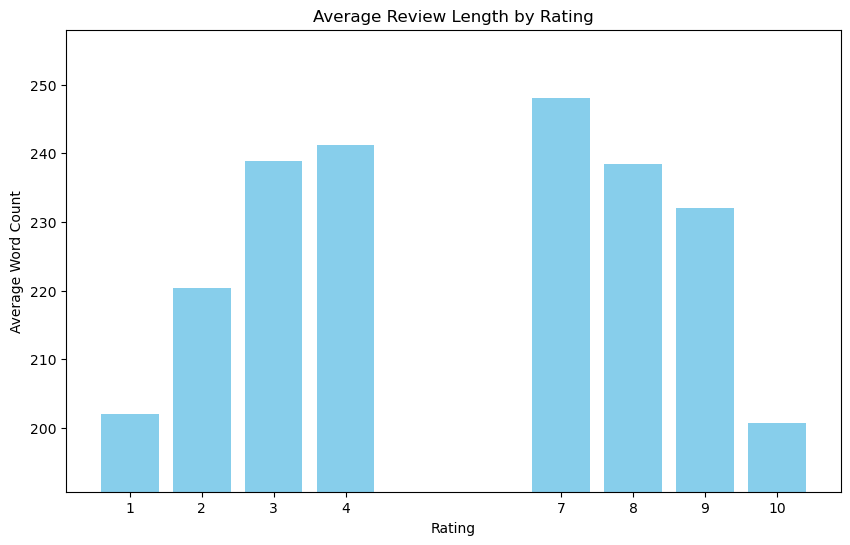

In [48]:
import matplotlib.pyplot as plt

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(result_df['rating'], result_df['avg_word_count'], color='skyblue')

# Add titles and labels
plt.title('Average Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Word Count')
plt.xticks(result_df['rating'])

# Set y-axis limits
plt.ylim(min(result_df['avg_word_count']) - 10, max(result_df['avg_word_count']) + 10)

# Show the plot
plt.show()

### Most Common Words in Positive and Nagative Rated Movies
Identify the most common words in reviews with positive ratings and negative ratings

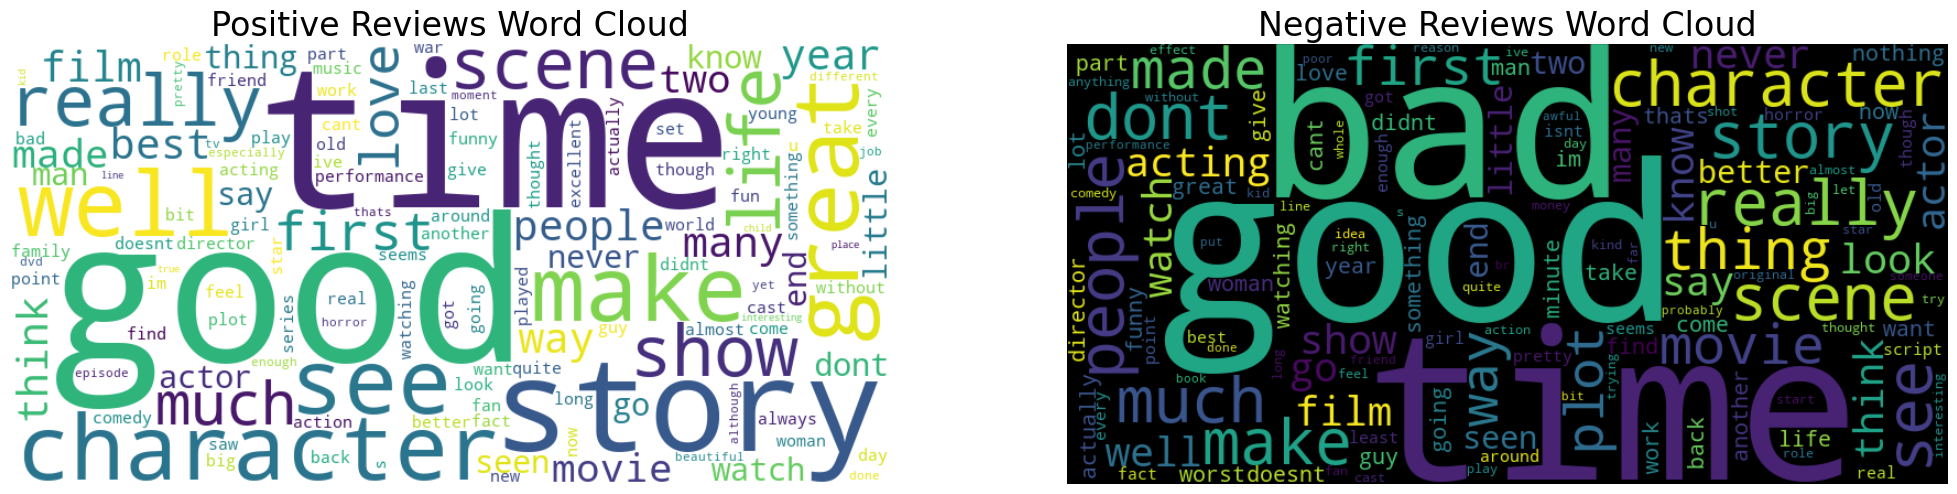

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Fetch positive reviews from the temporary view
positive_reviews_df = spark.sql("SELECT review FROM movie_reviews_view WHERE sentiment = 1")

# Fetch negative reviews from the temporary view
negative_reviews_df = spark.sql("SELECT review FROM movie_reviews_view WHERE sentiment = 0")

# Tokenize the review text into individual words and explode to flatten the array
positive_words = positive_reviews_df.withColumn("word", F.explode(F.split(F.col("review"), " ")))
negative_words = negative_reviews_df.withColumn("word", F.explode(F.split(F.col("review"), " ")))

# Count the frequency of each word in positive reviews
positive_word_freq = positive_words.groupBy("word").count().orderBy(F.desc("count")).filter(F.col("word") != "")

# Count the frequency of each word in negative reviews
negative_word_freq = negative_words.groupBy("word").count().orderBy(F.desc("count")).filter(F.col("word") != "")

# Collect the top 150 words for positive and negative reviews
positive_words_list = positive_word_freq.limit(150).select("word").rdd.flatMap(lambda x: x).collect()
negative_words_list = negative_word_freq.limit(150).select("word").rdd.flatMap(lambda x: x).collect()

# Create text for word clouds
positive_words_text = " ".join(positive_words_list)
negative_words_text = " ".join(negative_words_list)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_words_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_words_text)

# Plotting the word clouds
plt.figure(figsize=(25, 15))

# Positive review word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title("Positive Reviews Word Cloud", fontsize=24)
plt.axis('off')

# Negative review word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title("Negative Reviews Word Cloud", fontsize=24)
plt.axis('off')

plt.show()